# Digit Recognizer

### Download data

In [ ]:
from dblue_stores import StoreManager
store = StoreManager(dataset_id="dblue-demo-dataset")
store.download_dir("digit-recognizer", "/dblue/data")
!ls /dblue/data

### Install libraries

In [18]:
# install libraries
!pip3 install keras
!pip3 install numpy
!pip3 install pandas
!pip3 install bcolz
!pip3 install tensorflow
!pip3 install matplotlib
!pip3 install sklearn

     |████████████████████████████████| 6.7MB 3.2MB/s eta 0:00:01     |█▏                              | 245kB 3.2MB/s eta 0:00:02     |█████▊                          | 1.2MB 3.2MB/s eta 0:00:02     |█████████████████████████████▌  | 6.2MB 3.2MB/s eta 0:00:01
     |████████████████████████████████| 286kB 13.0MB/s eta 0:00:01
  Stored in directory: /root/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn


In [15]:
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers.convolutional import Conv2D, ZeroPadding2D, MaxPooling2D
from keras import optimizers

import pandas as pd
import numpy as np
import bcolz

In [9]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [10]:
train.shape

(42000, 785)

In [11]:
test.shape

(28000, 784)

### Split features and label

In [12]:
def get_dataset(train, test):
    train_features = train.iloc[:,1:]
    train_labels = train.iloc[:,0]
    train_features = np.array(train_features).astype(np.uint8)
    test_features = np.array(test).astype(np.uint8)
    return train_features, train_labels, test_features


train_features, train_labels, test_features = get_dataset(train, test)

### View Image

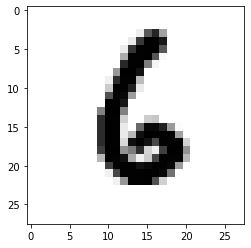

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

train_features = np.array(train_features).reshape((-1, 1, 28, 28)).astype(np.uint8)
test_features = np.array(test).reshape((-1, 1, 28, 28)).astype(np.uint8)

plt.imshow(train_features[1730][0], cmap=cm.binary) # draw the picture

### 1. Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [21]:
train_features, train_labels, test_features = get_dataset(train, test)

In [22]:
m = RandomForestClassifier(n_estimators=100)
m.fit(train_features, train_labels)
pred = m.predict(test_features)
pred

array([2, 0, 9, ..., 3, 9, 2])

In [23]:
scores = cross_val_score(m, train_features, train_labels, cv=5)
scores

array([0.96299822, 0.96334642, 0.96356709, 0.96510659, 0.96534064])

### 2. Basic Keras Model

Convert labels to one hot encoding - transforming the vector of class integers into a binary matrix.

In [24]:
train_features, train_labels, test_features = get_dataset(train, test)

In [25]:
train_labels = np_utils.to_categorical(train_labels)
train_labels.shape

(42000, 10)

Normalize inputs from 0-255 pixel to 0-1

In [26]:
train_features = train_features / 255.0
test_features = test / 255.0

In [28]:
num_pixels = train_features.shape[1]
num_classes = train_labels.shape[1]
print(num_pixels, num_classes)

784 10


In [29]:
def model(num_pixels, num_classes):
    # create model
    model = Sequential()
    model.add(Dense(num_pixels, input_dim=num_pixels, init='normal', activation='relu'))
    model.add(Dense(num_classes, init='normal', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [30]:
# build the model
m = model(num_pixels, num_classes)

W0716 15:05:04.765019 139873983162176 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(784, input_dim=784, activation="relu", kernel_initializer="normal")`
  after removing the cwd from sys.path.
W0716 15:05:04.951923 139873983162176 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0716 15:05:05.021885 139873983162176 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

/usr/local/lib/python3.7/site-packages/ipykernel

In [31]:
# Fit the model
m.fit(train_features, train_labels, validation_split=0.33, nb_epoch=10, batch_size=200, verbose=2)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  
W0716 15:05:31.831279 139873983162176 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0716 15:05:31.884489 139873983162176 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 28139 samples, validate on 13861 samples
Epoch 1/10
 - 6s - loss: 0.3946 - acc: 0.8900 - val_loss: 0.2091 - val_acc: 0.9390
Epoch 2/10
 - 5s - loss: 0.1617 - acc: 0.9537 - val_loss: 0.1542 - val_acc: 0.9538
Epoch 3/10
 - 5s - loss: 0.1088 - acc: 0.9688 - val_loss: 0.1159 - val_acc: 0.9655
Epoch 4/10
 - 5s - loss: 0.0768 - acc: 0.9795 - val_loss: 0.0998 - val_acc: 0.9701
Epoch 5/10
 - 5s - loss: 0.0570 - acc: 0.9850 - val_loss: 0.0943 - val_acc: 0.9711
Epoch 6/10
 - 5s - loss: 0.0422 - acc: 0.9897 - val_loss: 0.0968 - val_acc: 0.9697
Epoch 7/10
 - 5s - loss: 0.0320 - acc: 0.9933 - val_loss: 0.0860 - val_acc: 0.9739
Epoch 8/10
 - 5s - loss: 0.0227 - acc: 0.9952 - val_loss: 0.0879 - val_acc: 0.9721
Epoch 9/10
 - 5s - loss: 0.0173 - acc: 0.9971 - val_loss: 0.0830 - val_acc: 0.9751
Epoch 10/10
 - 5s - loss: 0.0130 - acc: 0.9982 - val_loss: 0.0831 - val_acc: 0.9763


In [35]:
def predict(model, test_features, save=True):
    prediction = m.predict(test_features)
    train_classes = prediction.argmax(axis=-1)

    if save:
        with open('result.csv', 'w') as f:
            f.write('ImageId,Label\n')

            for index, item in enumerate(train_classes):
                f.write("%d,%d\n" % (index + 1, item))
    return train_classes

In [36]:
predict(m, test_features)

array([2, 0, 9, ..., 3, 9, 2])

### 3. Simple Convolutional Neural Network

In [45]:
train_features, train_labels, test_features = get_dataset(train, test)

# reshape to be [samples][pixels][width][height]
train_features = train_features.reshape(-1, 1, 28, 28).astype('float32')
test_features = test_features.reshape(-1, 1, 28, 28).astype('float32')
train_features = train_features / 255.0
test_features = test_features / 255.0
train_labels = np_utils.to_categorical(train_labels)
num_classes = 10

In [48]:
def model(num_classes):
    # create model
    model = Sequential()
    model.add(Conv2D(32, (5, 5), input_shape=(1, 28, 28), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [39]:
train_labels

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [50]:
from keras import backend as K
K.set_image_dim_ordering('th')

m = model(num_classes)
# Fit the model
m.fit(train_features, train_labels, validation_split=0.33, nb_epoch=10, batch_size=200, verbose=2)


W0716 15:14:31.912947 139873983162176 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0716 15:14:31.940740 139873983162176 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 28139 samples, validate on 13861 samples
Epoch 1/10
 - 39s - loss: 0.3790 - acc: 0.8915 - val_loss: 0.1355 - val_acc: 0.9624
Epoch 2/10
 - 36s - loss: 0.1122 - acc: 0.9682 - val_loss: 0.0925 - val_acc: 0.9722
Epoch 3/10
 - 36s - loss: 0.0724 - acc: 0.9796 - val_loss: 0.0659 - val_acc: 0.9802
Epoch 4/10
 - 35s - loss: 0.0589 - acc: 0.9817 - val_loss: 0.0652 - val_acc: 0.9803
Epoch 5/10
 - 35s - loss: 0.0434 - acc: 0.9874 - val_loss: 0.0525 - val_acc: 0.9842
Epoch 6/10
 - 35s - loss: 0.0367 - acc: 0.9885 - val_loss: 0.0579 - val_acc: 0.9821
Epoch 7/10
 - 35s - loss: 0.0302 - acc: 0.9908 - val_loss: 0.0535 - val_acc: 0.9841
Epoch 8/10
 - 35s - loss: 0.0252 - acc: 0.9921 - val_loss: 0.0527 - val_acc: 0.9847
Epoch 9/10
 - 35s - loss: 0.0208 - acc: 0.9936 - val_loss: 0.0463 - val_acc: 0.9861
Epoch 10/10
 - 35s - loss: 0.0193 - acc: 0.9943 - val_loss: 0.0498 - val_acc: 0.9865


In [51]:
predict(m, test_features)

array([2, 0, 9, ..., 3, 9, 2])

### 4. Larger Convolutional Neural Network

In [55]:
def model(num_classes):
    # create model
    model = Sequential()
    model.add(Conv2D(30, (3, 3), input_shape=(1, 28, 28), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(15, 3, 3, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [56]:
m = model(num_classes)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(15, (3, 3), activation="relu")`
  


In [57]:
m.fit(train_features, train_labels, validation_split=0.33, nb_epoch=10, batch_size=200, verbose=2)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 28139 samples, validate on 13861 samples
Epoch 1/10
 - 39s - loss: 0.7280 - acc: 0.7708 - val_loss: 0.1794 - val_acc: 0.9475
Epoch 2/10
 - 39s - loss: 0.1775 - acc: 0.9469 - val_loss: 0.1099 - val_acc: 0.9683
Epoch 3/10
 - 39s - loss: 0.1186 - acc: 0.9633 - val_loss: 0.0812 - val_acc: 0.9745
Epoch 4/10
 - 39s - loss: 0.0951 - acc: 0.9696 - val_loss: 0.0657 - val_acc: 0.9804
Epoch 5/10
 - 39s - loss: 0.0801 - acc: 0.9753 - val_loss: 0.0585 - val_acc: 0.9817
Epoch 6/10
 - 39s - loss: 0.0643 - acc: 0.9795 - val_loss: 0.0522 - val_acc: 0.9841
Epoch 7/10
 - 40s - loss: 0.0590 - acc: 0.9806 - val_loss: 0.0479 - val_acc: 0.9847
Epoch 8/10
 - 38s - loss: 0.0507 - acc: 0.9830 - val_loss: 0.0446 - val_acc: 0.9861
Epoch 9/10
 - 38s - loss: 0.0467 - acc: 0.9848 - val_loss: 0.0470 - val_acc: 0.9861
Epoch 10/10
 - 39s - loss: 0.0406 - acc: 0.9869 - val_loss: 0.0474 - val_acc: 0.9857


In [58]:
predict(m, test_features)

array([2, 0, 9, ..., 3, 9, 2])